# __Hands-on with TensorFlow: Part A__

Let's see how TensorFlow works and build a deep neural network model using the MNIST dataset.

## Steps to be followed:
1. Import TensorFlow
2. Load the MNIST dataset
3. Create the model
4. Get predictions from the model
5. Apply softmax activation to the predictions
6. Define the loss function
7. Compile the model
8. Train the model
9. Evaluate the model
10. Create a probability model

## Step 1: Import TensorFlow

- Import TensorFlow and check its version


In [1]:
import os
import tensorflow as tf
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(f"TF version: {tf.__version__}, Keras: {tf.keras.__version__}")


def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

TF version: 2.19.0, Keras: 3.10.0


## Step 2: Load the MNIST Dataset

- Load the MNIST dataset and normalize the input data by dividing the train and test sets by 255



In [90]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"X Shape={x_train.shape}, y_train: {y_train.shape}, image={x_train[0].shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")

X Shape=(60000, 28, 28), y_train: (60000,), image=(28, 28)
X_test: (10000, 28, 28), y_test: (10000,)


In [3]:
# Normalize to 1
X_train = x_train / 255.0
X_test = x_test / 255.0

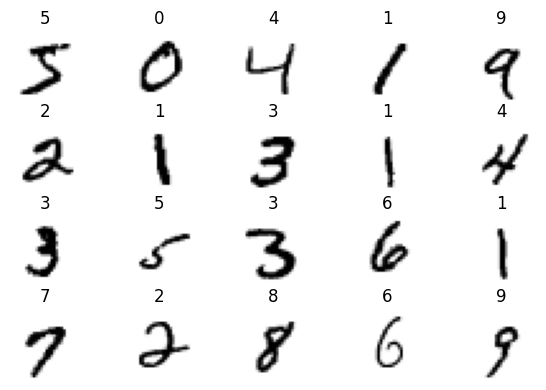

In [4]:
# Show some examples
import matplotlib.pyplot as plt
import numpy as np
n_images = 20
test_images = X_train[:n_images]

fig, axes = plt.subplots(4,5, figsize=(6,4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(test_images[i], [28, 28]), cmap='binary')
    ax.axis('off')
    ax.set_title(y_train[i])
plt.tight_layout(h_pad=.0, w_pad=1.0)
plt.show()

__Observation:__
The dataset has been downloaded. The:
  - 1st dim: sample number
  - 2nd dim: Line of pixes in image
  - 3rd dim: Line of pixles in column

## Step 3: Create the Model

- Create a Sequential model with Flatten, Dense, and Dropout layers
- 1st layer: flatten
- 2nd layer: Dense, 128 nodes, activation = sigmoid
- 3rd layer: Dense, 64 nodes, activation=relu
- 4th layer: Dense, no activation; select the appropriate number of nodes

`Dense` implements the operation: `output = activation(dot(input, kernel) + bias)` where:
  - `activation` is the element-wise activation function passed as the `activation` argument, 
  - `kernel` is a weights matrix created by the layer, and 
  - `bias` is a bias vector created by the layer (only applicable if `use_bias` is `True`).

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    # units: dimensionality of the output space.
    # Got these values after tuning on GPUs.
    tf.keras.layers.Dense(units=300, activation="relu"),
    tf.keras.layers.Dense(units=150, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax")
    ])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [78]:
def fit_callbacks():
    # Add TensorBoard callback
    tensorboard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=get_run_logdir(),
        histogram_freq=1,      # Optional: logs weights/activations histograms
        write_graph=True,
        write_images=True)

    # Add learning rate tracking to TensorBoard ===
    class LRTensorBoard(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate

            if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
                lr = lr(epoch)
            tf.summary.scalar('learning rate', data=lr, step=epoch)


    lr_tracker_cb = LRTensorBoard()

    # Add ReduceLROnPlateau and EarlyStopping
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    early_stop_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    # Layer callbacks
    return [tensorboard_cb, lr_tracker_cb, reduce_lr_cb, early_stop_cb]

In [79]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

In [80]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=1_000,
                    callbacks=fit_callbacks())

Epoch 1/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - accuracy: 0.9458 - loss: 0.1845 - val_accuracy: 0.9648 - val_loss: 0.1199 - learning_rate: 0.0010
Epoch 2/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.9638 - loss: 0.1212 - val_accuracy: 0.9708 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 3/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - accuracy: 0.9727 - loss: 0.0900 - val_accuracy: 0.9747 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 4/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9787 - loss: 0.0683 - val_accuracy: 0.9745 - val_loss: 0.0896 - learning_rate: 0.0010
Epoch 5/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.9838 - loss: 0.0525 - val_accuracy: 0.9758 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 6/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - accuracy: 0.9875 - loss: 0.0402 - val_accuracy: 0.9742 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 7/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/s

## Step 4: Get Predictions from the Model

- Get the predictions from the model using the train data for one column, as the optimizer is not yet applied


In [9]:
# CODE HERE: preliminary predictions (the model has not beed trained yet)
prediction = np.argmax(model(x_train[:1]))
prediction, y_train[0]

(np.int64(3), np.uint8(5))

__Observation:__
- An array of predicted values is displayed.

## Step 5: Apply Softmax Activation to the Predictions

- Apply softmax activation to the predictions and print the output in terms of probabilities. We can manually compute the softmax of final predication as:



__Observation:__
- The predicted values in terms of probabilities are displayed as an array.

## Step 6: Define the Loss Function

- Let's create a loss function for the model.
- Next, let's define the SparseCategoricalCrossentropy loss function.

__Remark:__ `from_logits=True` indicates that we haven't included softmax in the model. Python will apply the softmax to the output itself.


In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # 1st layer
    tf.keras.layers.Dense(units=128, activation='sigmoid'),  # 2nd layer
    tf.keras.layers.Dense(units=64, activation='relu'),  # 3rd layer
    tf.keras.layers.Dense(units=10, activation=None)  # 4th layer
])
model2.compile(optimizer='adam',  # Adam is an improved gradient descent
               loss=tf.keras.losses.SparseCategoricalCrossentropy(
                   from_logits=True),
               metrics=['Accuracy'])
model2.fit(X_train, y_train, epochs=20)

Epoch 1/20


/Users/xyz-ai/Developer/python3-code/ml/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step - Accuracy: 0.8277 - loss: 0.6152
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - Accuracy: 0.9476 - loss: 0.1770
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - Accuracy: 0.9636 - loss: 0.1235
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - Accuracy: 0.9736 - loss: 0.0838
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - Accuracy: 0.9805 - loss: 0.0646
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - Accuracy: 0.9845 - loss: 0.0493
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - Accuracy: 0.9884 - loss: 0.0397
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - Accuracy: 0.9900 - loss: 0.0315
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - Accuracy: 0.9930 - loss: 0.0239
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - Accuracy: 0.9943 - loss: 0.0190
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - Accuracy: 0.9952 - loss: 0.0158
Epoch 12/20
1875/18

In [11]:
# Use "from_logits=True" when there is no activation in the last layer
# Use CategoricalCrossentropy when the training output are categories that are one-hot encoded
# Use SparseCategoricalCrossentropy when the training output are categories that are NOT one-hot encoded
#
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
prediction

np.int64(3)

In [13]:
# Test loss function on 1 example
loss_fn(y_train[:1], model(x_train[:1]))

/Users/xyz-ai/Developer/python3-code/ml/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


<tf.Tensor: shape=(), dtype=float32, numpy=125.46923828125>

If we wanted to manually calculate cross-entropy this would have been done this,

```python
# Test loss function on 1 example
loss_fn(y_train[:1], model(x_train[:1]))
```

## Step 7: Compile the Model

- Now, compile the model with the Adam optimizer, the loss function, and the accuracy metric

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

__Display model summary__

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,760 (1.13 MB)

 Trainable params: 296,760 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

__Observation:__
- Here, we have used an optimizer as Adam, loss as a loss function, and metrics as accuracy.

## Step 8: Train the Model

- Fit the model using the training data for 5 epochs


In [16]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=1_000,
                    callbacks=fit_callbacks())

Epoch 1/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9885 - loss: 0.0342 - val_accuracy: 0.9778 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9911 - loss: 0.0275 - val_accuracy: 0.9788 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 3/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.0261 - val_accuracy: 0.9803 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 4/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9933 - loss: 0.0217 - val_accuracy: 0.9825 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 5/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9935 - loss: 0.0177 - val_accuracy: 0.9805 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 6/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9947 - loss: 0.0173 - val_accuracy: 0.9750 - val_loss: 0.1148 - learning_rate: 0.0010
Epoch 7/1000
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accura

__Observations:__
- The model fits the data.
- Here, we can see that the accuracy is increased by different epochs.

## Step 9: Evaluate the Model

- Evaluate the model using the testing data and print the results


In [81]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.9671 - loss: 0.1570


[0.13638459146022797, 0.9704999923706055]

__Observation:__

- The accuracy score is 0.9779, and the loss is 0.071.

## Step 10: Create a Probability Model

- Create a probability model by adding the Softmax layer to the existing model.

In [82]:
probability_model = tf.keras.Sequential([
    model2,
    tf.keras.layers.Softmax()
])
probability_model.compile(optimizer="adam", loss=loss_fn, metrics=['Accuracy'])

- Get the predictions using the test data

In [83]:
my_predictions = probability_model(x_test)
my_predictions[:2]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[3.1011706e-14, 2.8183493e-17, 1.0810791e-11, 1.4722433e-05,
        1.0952835e-19, 1.4313962e-12, 1.1470985e-27, 9.9998522e-01,
        3.3844067e-13, 1.3961134e-09],
       [2.5813482e-13, 5.7894784e-08, 1.0000000e+00, 3.3316988e-10,
        6.0553856e-17, 1.4253120e-12, 1.1288217e-14, 3.0665263e-13,
        1.2703192e-17, 5.0439794e-21]], dtype=float32)>

__Observation:__
- Here, we have the probabilities for the first three observations and different classes.

__Make predictions for all X_test__

In [84]:
y_pred = probability_model(X_test)
probability_model.evaluate(X_test, y_test)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:04 208ms/step - Accuracy: 1.0000 - loss: 2.2804e-05

/Users/xyz-ai/Developer/python3-code/ml/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - Accuracy: 0.9740 - loss: 0.1328  


[0.11870238929986954, 0.9767000079154968]

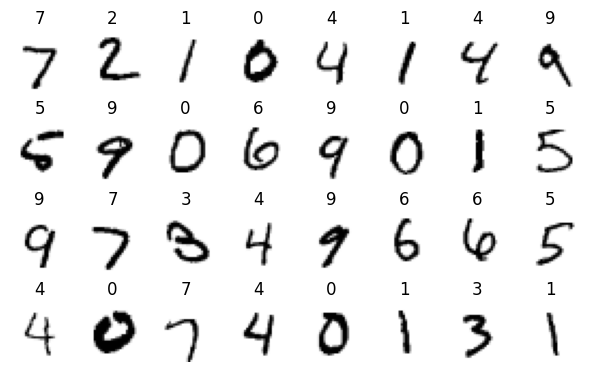

In [85]:
# Show some examples of predictions for the test set
n_images = 32
test_images = X_test[:n_images]

fig, axes = plt.subplots(4, 8, figsize=(6, 4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(test_images[i], [28, 28]), cmap='binary')
    ax.axis('off')
    ax.set_title(np.argmax(y_pred.numpy()[i]))
plt.tight_layout(h_pad=.0, w_pad=1.0)
plt.show()

## Other way of coding the last layer of the model

- Create a Sequential model with Flatten, Dense, and Dropout layers
- 1st layer: flatten
- 2nd layer: Dense, 128 nodes, activation = relu
- 3rd layer: Dropout
- 4th layer: Dense, activation = softmax

In [25]:
# Define model
last_model = model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    # units: dimensionality of the output space.
    # Got these values after tuning on GPUs.
    tf.keras.layers.Dense(units=128, activation="sigmoid"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [26]:
# Compile
last_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [27]:
# Train
last_model.fit(X_train, y_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - accuracy: 0.8306 - loss: 0.6168


In [28]:
# Evaluate
last_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9306 - loss: 0.2428


[0.21604280173778534, 0.9376000165939331]

In [29]:
# Predict
predictions2 = last_model(x_test)
print(predictions2[0])
print(np.argmax(predictions2[0]))

tf.Tensor(
[1.4478760e-06 4.0114813e-08 4.4063222e-06 3.2144337e-05 6.4305063e-09
 5.4102395e-07 2.0192079e-09 9.9990529e-01 1.8447447e-07 5.5946104e-05], shape=(10,), dtype=float32)
7


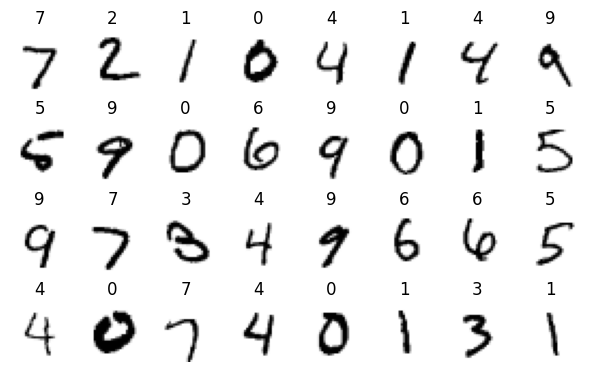

In [31]:
# Show some examples
n_images = 30
test_images = x_test[:n_images]
predictions = last_model(test_images)

n_images = 32
test_images = X_test[:n_images]

fig, axes = plt.subplots(4, 8, figsize=(6, 4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(test_images[i], [28, 28]), cmap='binary')
    ax.axis('off')
    ax.set_title(np.argmax(y_pred.numpy()[i]))
plt.tight_layout(h_pad=.0, w_pad=1.0)
plt.show()

## Store model History

What information is stroed in history.

In [86]:
my_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28)), # 1st Layer
    tf.keras.layers.Flatten(), # 1st Layer
    tf.keras.layers.Dense(units=128, activation='sigmoid'), # 2nd Layer
    tf.keras.layers.Dense(units=64, activation='relu'), # 3rd Layer
    tf.keras.layers.Dense(units=10, activation='softmax') # 4th Layer
])
my_model2.compile(optimizer='adam',  # Adam is an imporved gradient descent
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['Accuracy'])

In [87]:
history = my_model2.fit(X_train, y_train,
                        validation_split=0.2, epochs=80, callbacks=fit_callbacks())

Epoch 1/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - Accuracy: 0.8117 - loss: 0.6952 - val_Accuracy: 0.9362 - val_loss: 0.2285 - learning_rate: 0.0010
Epoch 2/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - Accuracy: 0.9416 - loss: 0.1972 - val_Accuracy: 0.9561 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 3/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - Accuracy: 0.9598 - loss: 0.1336 - val_Accuracy: 0.9628 - val_loss: 0.1301 - learning_rate: 0.0010
Epoch 4/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - Accuracy: 0.9699 - loss: 0.0978 - val_Accuracy: 0.9675 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 5/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - Accuracy: 0.9765 - loss: 0.0766 - val_Accuracy: 0.9682 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 6/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - Accuracy: 0.9821 - loss: 0.0593 - val_Accuracy: 0.9704 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 7/80
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - Accura

In [92]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['Accuracy'], label='accuracy')
    plt.plot(history.history['val_Accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

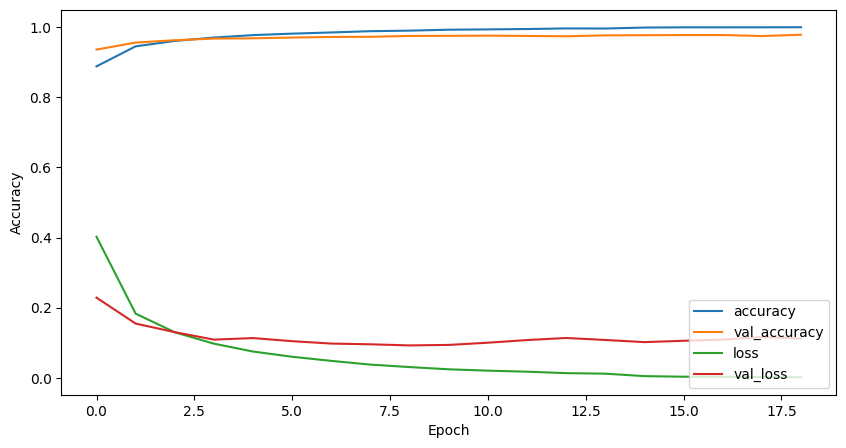

In [93]:
plot_history(history)


__Note:__ The train accuracy and validaiton accuracy is similary high. So no sign of overfitting.